# Assignment 2

`“For even the very wise cannot see all ends.”
-J.R.R. Tolkien, The Fellowship of the Ring`

---

## Libraries

#### IMPORTANT NOTES:

- Moving forward, we'll be using `ETSModel` from `statsmodels.tsa.exponential_smoothing.ets`.
- Use the `display` function from `IPython.display` for printing pandas dataframes.

In [1]:
pip install statsmodels==0.12.2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [137]:
import warnings
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from IPython.display import display
from tsa_functions import *

register_matplotlib_converters()
sns.set_style('darkgrid')

np.set_printoptions(precision=4)
pd.set_option('precision', 4)

# Real men ignore warnings
warnings.filterwarnings("ignore")

In [3]:
sm.__version__

'0.12.2'

In [4]:
def mae(y_true, y_pred):
    score = np.mean(np.abs(y_true - y_pred))
    return score


def rmse(y_true, y_pred):
    score = np.sqrt(np.mean((y_true - y_pred)**2))
    return score


def mase(y_true, y_pred, s_ts):
    ts = s_ts.to_numpy()
    score = np.mean(
        np.abs((y_true - y_pred)/np.mean(np.abs(ts[1:] - ts[:-1]))))
    return score


def rateMyForecast(train, test, forecast):
    """
    Evalute the forcast per group, given train, test, and forecast tables.

    The function evaluates the metrics per column of the provided table.

    Parameters
    ----------
    train : DataFrame
        DataFrame contaning the train set.
    test : DataFrame
        DataFrame contaning the train set.
    forecast : DataFrame
        DataFrame contaning the train set.

    Returns
    -------
    DataFrame
        DataFrame contaning the metrics as columns, groups as rows,
        and scores as values.

    """
    res = pd.DataFrame([
        {'Group': col,
         'RMSE': rmse(test[col], forecast[col]),
         'MAE': mae(test[col], forecast[col]),
         'MASE': mase(test[col], forecast[col], train[col])}
        for col in test])
    display(res.set_index('Group'))
    return res.set_index('Group')

---

## Forecasting Australian Domestic Tourism

For this homework, we'll be continuing our exploration of forecasting hierarchical and grouped time series following [FPP3](https://otexts.com/fpp3/hierarchical.html).

Load the Australian domestic tourism dataset and perform the following:

- Recode the `State` variable, similar to what we did in the discussion notebook.

- Create a hierarchical time series with overnight trips in regions at the bottom level of the hierarchy (which can then be aggregated to states, then aggregated to the national `Total`), similar to what we did in the discussion notebook.

- Re-index the series using `pd.period_range` instead of the strings in `Quarter`.

Withhold the last two years (8 quarters) as a test set for evaluation. Use the rest for training.

In [5]:
state_dict = {
    'New South Wales': 'NSW',
    'Northern Territory': 'NT',
    'Queensland': 'QLD',
    'South Australia': 'SA',
    'Tasmania': 'TAS',
    'Victoria': 'VIC',
    'Western Australia': 'WA'}
df = pd.read_csv('special_datasets/tourism.csv')
df.State.replace(state_dict, inplace=True)

df.index = pd.DatetimeIndex(df.Quarter).to_period('Q')
# df['Year'] = pd.to_datetime(df.Quarter).dt.year
# df['Quarter'] = pd.to_datetime(df.Quarter).dt.quarter

df_pivot = df.pivot_table(
    values='Trips',
    index=df.index,
    columns=['State', 'Region'],
    aggfunc=np.sum)

df_train_bu = df_pivot.loc[:'2015Q4']
df_test_bu = df_pivot.loc['2016Q1':]
display(df_train_bu, df_test_bu)

State         ACT            NSW                                            \
Region   Canberra Blue Mountains Capital Country Central Coast Central NSW   
Quarter                                                                      
1998Q1   551.0019       195.5432        261.8081      455.1668    424.3954   
1998Q2   416.0256       200.4087        238.6000      343.4768    557.0116   
1998Q3   436.0290       253.3597        184.4238      303.6709    555.5280   
1998Q4   449.7984       245.5738        229.0889      331.8171    590.1584   
1999Q1   378.5728       290.4841        252.2820      466.8156    480.1293   
...           ...            ...             ...           ...         ...   
2014Q4   526.9391       202.2309        252.6499      312.2192    535.2692   
2015Q1   566.1355       155.0849        256.9625      418.7622    378.2065   
2015Q2   516.8703       312.2449        215.3308      244.0471    530.0010   
2015Q3   688.2032       191.6364        287.8541      258.2806    473.7973   
2015Q4   597.2456       226.2409        345.6945      339.2346    549.6517   

State                                                                 \
Region     Hunter New England North West North Coast NSW Outback NSW   
Quarter                                                                
1998Q1   674.9785               329.8385       1342.3012     96.6027   
1998Q2   791.8872               328.3660       1161.1086    120.6484   
1998Q3   566.0406               324.8592        839.3681    110.0738   
1998Q4   591.5689               279.7962       1183.8600    185.4700   
1999Q1   785.1028               327.4919       1306.8775     78.3638   
...           ...                    ...             ...         ...   
2014Q4   785.3634               337.7434       1178.5194    104.2203   
2015Q1   838.8067               335.5004       1306.6054     68.1654   
2015Q2   764.0549               379.5845       1193.6271    112.0811   
2015Q3   699.6875               294.5415       1097.9386    126.2728   
2015Q4   831.2333               300.3492       1266.5966    105.1184   

State              ...            VIC                          \
Region   Riverina  ... Phillip Island Spa Country Upper Yarra   
Quarter            ...                                          
1998Q1   215.2689  ...       364.0433     86.1960    102.7910   
1998Q2   336.0949  ...       166.2436     74.3569     74.8551   
1998Q3   228.0654  ...        83.0328     60.7785     59.4654   
1998Q4   201.1235  ...       215.6779     46.0133     35.2389   
1999Q1   200.8224  ...       263.7101     65.2992     67.8235   
...           ...  ...            ...         ...         ...   
2014Q4   254.2813  ...       203.0495     63.2429     76.8980   
2015Q1   253.1515  ...       266.8429     88.3428     48.0880   
2015Q2   260.6241  ...       194.8407     71.6348     65.1461   
2015Q3   264.2596  ...       123.6403     87.3951     34.4699   
2015Q4   240.0733  ...       209.0388     78.8902     63.2864   

State                                                   WA  \
Region  Western Grampians  Wimmera Australia's Coral Coast   
Quarter                                                      
1998Q1            86.9966  18.8047                132.5164   
1998Q2            84.9400  52.4823                172.6154   
1998Q3            79.9749  35.6576                173.9043   
1998Q4           116.2356  27.2045                207.0026   
1999Q1           101.7656  50.2199                198.8566   
...                   ...      ...                     ...   
2014Q4            79.4137  39.4071                269.6209   
2015Q1            77.2792  36.5637                226.7946   
2015Q2            70.1937  26.2152                313.2486   
2015Q3           105.2092  25.0743                244.3433   
2015Q4            55.9837  38.5689                316.1071   

State                                                      \
Region  Australia's Golden Outback Australia's North West

State         ACT            NSW                                            \
Region   Canberra Blue Mountains Capital Country Central Coast Central NSW   
Quarter                                                                      
2016Q1   625.1416       227.4607        306.4441      398.0859    508.6850   
2016Q2   592.6085       303.5584        322.5047      250.9560    461.0432   
2016Q3   572.4371       211.0181        262.9282      265.4521    505.2368   
2016Q4   667.2141       220.1716        277.3330      379.4839    525.2546   
2017Q1   634.3687       190.4739        300.0212      455.0586    529.9431   
2017Q2   748.2904       315.7889        305.7111      278.4784    651.3597   
2017Q3   631.7599       314.6307        287.2512      272.4384    628.5964   
2017Q4   720.3294       203.4606        356.3841      427.7658    628.2281   

State                                                                  \
Region      Hunter New England North West North Coast NSW Outback NSW   
Quarter                                                                 
2016Q1    842.8019               321.2152       1560.8200     65.6794   
2016Q2    829.9771               392.0172       1153.6977    134.8313   
2016Q3    801.0572               350.3716       1038.7536    141.2427   
2016Q4    843.7873               346.6872       1407.1824    105.9467   
2017Q1    757.0282               358.0866       1409.7407     91.1370   
2017Q2    897.9597               405.9132       1164.0613    107.5434   
2017Q3    914.8204               398.9737       1145.6544    162.5924   
2017Q4   1004.3339               404.1934       1329.1106    106.3099   

State              ...            VIC                          \
Region   Riverina  ... Phillip Island Spa Country Upper Yarra   
Quarter            ...                                          
2016Q1   238.9226  ...       327.2870     91.9398     38.0968   
2016Q2   279.9532  ...       168.6530     82.1689     63.6975   
2016Q3   254.5432  ...       145.2257     77.7021     52.0486   
2016Q4   230.6681  ...       189.9613    114.6199     59.6499   
2017Q1   182.6422  ...       339.8957     87.9224    114.1359   
2017Q2   293.5650  ...       196.4758     56.1299     93.9915   
2017Q3   213.9023  ...       156.0623    100.1157     39.8043   
2017Q4   218.1398  ...       238.1329     95.3488     75.0986   

State                                                   WA  \
Region  Western Grampians  Wimmera Australia's Coral Coast   
Quarter                                                      
2016Q1            95.9714  42.6252                284.5467   
2016Q2            49.5275  24.4022                279.9112   
2016Q3            70.2469  24.4363                254.0475   
2016Q4           102.3744  25.7099                256.8122   
2017Q1            92.9616  62.9338                241.9544   
2017Q2            71.5968  41.8446                223.8558   
2017Q3            56.8456  62.5967                282.3629   
2017Q4           119.9106  45.1500                274.7947   

State                                                      \
Region  Australia's Golden Outback Australia's North West   
Quarter                                                     
2016Q1                    278.3108               209.7269   
2016Q2                    288.9768               289.8143   
2016Q3                    271.1387               424.9869   
2016Q4                    269.9291               316.2068   
2017Q1                    225.9662               226.5482   
2017Q2                    256.3540               285.7901   
2017Q3                    306.1539               352.1124   
2017Q4                    223.7437               288.6869   

State                                            
Region  Australia's South West Experience Perth  
Quarter                                          
2016Q1                982.0733        1116.5143  
2016Q2                650.1197         960.5722  
2016Q3          

### Q.

Suppose we wanted to use a bottom-up (BU) approach to forecast this hierarchical time series.

How many time series do we need to forecast?

### Answer.

`There needed to be as much forecasts as the number of bottom level groups; in which case, that number is 76—corresponding to the number of columns in our pivot table, df_pivot.`

In [6]:
df_pivot.columns.size

76

### Q.

What is an `ETS(A,A,A)` model?

### Answer.

`The ETS(A,A,A) model is thus named to refer to the method using which each component is forecasted. The three letters refer respectively to the method used in Exponential Smoothing for Error, Trend, and Seasonal components. Three A's (jsut like my initials), refers to:`
* `Additive Error,`
* `Additive Trend, and`
* `Additive Seasonality`

`Or as one would call it: Additive Holt-Winters’ Method with Additive Errors`

### Q.

Using a bottom-up (BU) approach, generate 8-step forecasts using an `ETS(A,A,A)` model for all series.

Calculate the `RMSE`, `MAE`, and `MASE` metrics at each level (i.e. `Total`, `State`, `Region`).

Print the metrics as a dataframe. (For `Region`, no need to show the all the rows.)

#### Training Proper

In [7]:
# Train! All the models!
model_dict = {}
for label, content in df_train_bu.items():
    model = ETSModel(
        content, error='add', trend='add', seasonal='add', seasonal_periods=4)
    fit = model.fit()
    model_dict[label] = fit

display(model_dict)  # Our model bunch

{('ACT',
  'Canberra'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f07746829d0>,
 ('NSW',
  'Blue Mountains'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f06fe687fd0>,
 ('NSW',
  'Capital Country'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f07027f5460>,
 ('NSW',
  'Central Coast'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f06fc642190>,
 ('NSW',
  'Central NSW'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f07027f5c10>,
 ('NSW',
  'Hunter'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f07027f5dc0>,
 ('NSW',
  'New England North West'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f06fc642340>,
 ('NSW',
  'North Coast NSW'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f06fc651340>,
 ('NSW',
  'Outback NSW'): <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper at 0x7f06fc651d30>,
 ('NSW',
  '

#### Forecasting Proper

In [8]:
# Forecast! All the TS!
h = 8
df_forecast_bu = pd.DataFrame({
    index: fitted_model.forecast(h)
    for index, fitted_model
    in model_dict.items()
})

df_forecast_bu.index = df_test_bu.index

#### Evaluation Proper

##### Region Level

In [9]:
display(df_forecast_bu)
bu_reg = rateMyForecast(df_train_bu, df_test_bu, df_forecast_bu)

ACT            NSW                                            \
         Canberra Blue Mountains Capital Country Central Coast Central NSW   
Quarter                                                                      
2016Q1   556.3823       209.0347        263.3871      398.5323    429.9539   
2016Q2   573.4037       253.4083        232.7841      277.2481    501.5797   
2016Q3   572.8307       233.9315        259.4688      250.4715    486.2876   
2016Q4   569.8074       213.9191        309.9047      313.2573    506.4737   
2017Q1   561.2240       216.6164        267.7303      395.8067    428.3227   
2017Q2   578.2454       260.9899        237.1273      274.5225    499.9485   
2017Q3   577.6724       241.5132        263.8121      247.7459    484.6564   
2017Q4   574.6491       221.5007        314.2479      310.5317    504.8425   

                                                                      \
           Hunter New England North West North Coast NSW Outback NSW   
Quarter                                                                
2016Q1   803.3873               318.1043       1389.2268     59.9251   
2016Q2   743.6626               331.9944       1149.4799     97.4866   
2016Q3   693.2535               330.0521       1094.5030    122.6201   
2016Q4   753.9571               300.2158       1241.7905     93.4649   
2017Q1   807.5600               317.7601       1393.9423     66.1047   
2017Q2   747.8353               331.6503       1154.1954    103.6662   
2017Q3   697.4262               329.7080       1099.2185    128.7998   
2017Q4   758.1298               299.8717       1246.5060     99.6445   

                   ...            VIC                          \
         Riverina  ... Phillip Island Spa Country Upper Yarra   
Quarter            ...                                          
2016Q1   219.6126  ...       291.2084     71.4326     58.4488   
2016Q2   255.0354  ...       156.8426     74.9258     46.8279   
2016Q3   238.1753  ...       115.0154     63.9630     28.0341   
2016Q4   254.3432  ...       186.2478     63.4378     44.0535   
2017Q1   219.6102  ...       291.6223     71.7614     56.9427   
2017Q2   255.0329  ...       157.2565     75.2547     45.3218   
2017Q3   238.1728  ...       115.4293     64.2919     26.5280   
2017Q4   254.3407  ...       186.6617     63.7666     42.5474   

                                                        WA  \
        Western Grampians  Wimmera Australia's Coral Coast   
Quarter                                                      
2016Q1            67.1231  23.5174                285.3276   
2016Q2            77.8412  27.9237                322.3476   
2016Q3            72.4777  24.9333                328.2514   
2016Q4            83.2010  32.0142                325.3852   
2017Q1            72.4764  23.2113                320.0419   
2017Q2            83.1944  27.6176                357.0619   
2017Q3            77.8310  24.6272                362.9657   
2017Q4            88.5542  31.7081                360.0995   

                                                           \
        Australia's Golden Outback Australia's North West   
Quarter                                                     
2016Q1                    255.9398               307.5524   
2016Q2                    248.9110               386.1273   
2016Q3                    271.7201               440.2331   
2016Q4                    269.1101               399.4974   
2017Q1                    260.7933               389.3129   
2017Q2                    253.7645               467.8878   
2017Q3                    276.5736               521.9936   
2017Q4                    273.9636               481.2579   

                                                 
        Australia's South West Experience Perth  
Quarter                                          
2016Q1                874.6052        1071.5013  
2016Q2                760.3952        1014.8029  
2016Q3                632.0328        100

,RMSE,MAE,MASE
Group,,,
"(ACT, Canberra)",95.5239,78.5903,1.2249
"(NSW, Blue Mountains)",39.9635,33.7302,0.9198
"(NSW, Capital Country)",48.7953,41.9073,0.9679
"(NSW, Central Coast)",53.8306,39.1350,0.4844
"(NSW, Central NSW)",98.5827,84.6694,1.3251
...,...,...,...
"(WA, Australia's Coral Coast)",78.7600,70.3994,2.2045
"(WA, Australia's Golden Outback)",28.9901,22.6317,0.7916
"(WA, Australia's North West)",137.6640,124.9987,2.4114


##### State Level

In [10]:
display(df_forecast_bu.sum(level=0, axis=1))
bu_sta = rateMyForecast(
    df_train_bu.sum(level=0, axis=1),
    df_test_bu.sum(level=0, axis=1),
    df_forecast_bu.sum(level=0, axis=1))

,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Quarter,,,,,,,,
2016Q1,556.3823,7917.7487,258.7882,5045.1534,1706.7063,950.9208,6015.3220,2794.9263
2016Q2,573.4037,7252.8478,447.5650,5285.8339,1538.4222,676.5596,5211.4499,2732.5840
2016Q3,572.8307,7138.7800,585.7664,5717.1679,1395.7915,483.0904,4788.7639,2680.3016
2016Q4,569.8074,7550.6050,352.2441,5332.8911,1611.5647,665.9848,5297.1399,2801.8099
2017Q1,561.2240,8027.8380,263.1990,5120.9619,1753.0072,953.1737,6089.9644,2952.8374
2017Q2,578.2454,7362.9371,451.9757,5361.6424,1584.7231,678.8125,5286.0923,2890.4952
2017Q3,577.6724,7248.8693,590.1771,5792.9764,1442.0924,485.3433,4863.4063,2838.2127
2017Q4,574.6491,7660.6943,356.6549,5408.6996,1657.8656,668.2378,5371.7823,2959.7210


,RMSE,MAE,MASE
Group,,,
ACT,95.5239,78.5903,1.2249
NSW,647.2185,569.5520,1.2749
NT,83.5261,59.6239,0.3669
QLD,443.3913,364.1625,0.9603
SA,123.0756,108.8188,0.6447
TAS,126.1874,115.5216,0.4913
VIC,874.7931,775.0238,1.1854
WA,316.5927,293.7911,2.5114


##### Total

In [11]:
df_forecast_bu_total = df_forecast_bu.sum(axis=1).rename('Total').to_frame()
display(df_forecast_bu_total)
bu_tot = rateMyForecast(
    df_train_bu.sum(axis=1).rename('Total').to_frame(),
    df_test_bu.sum(axis=1).rename('Total').to_frame(),
    df_forecast_bu_total)

,Total
Quarter,
2016Q1,25245.9481
2016Q2,23718.6662
2016Q3,23362.4925
2016Q4,24182.0470
2017Q1,25722.2056
2017Q2,24194.9237
2017Q3,23838.7500
2017Q4,24658.3045


,RMSE,MAE,MASE
Group,,,
Total,1944.8443,1783.8892,1.6056


### Q.

Using a top-down (TD) approach with `average historical proportions`, generate 8-step forecasts using an `ETS(A,A,A)` model.

Calculate the `RMSE`, `MAE`, and `MASE` metrics at each level (i.e. `Total`, `State`, `Region`).

Print the metrics as a dataframe. (For `Region`, no need to show the all the rows.)

#### Training Proper

In [12]:
# Train! All the models!
df_train_td = df_train_bu.sum(axis=1).rename('Total').to_frame()
df_test_td = df_test_bu.sum(axis=1).rename('Total').to_frame()

model = ETSModel(
    df_train_td['Total'],
    error='add', trend='add', seasonal='add', seasonal_periods=4)
fit = model.fit(maxiter=10_000, optimized=True)
fit

In [13]:
# Get! All the Proportions!
props_region = (
    df_train_bu
    .apply(lambda x: x/x.sum(), axis='columns')
    .mean(axis='rows'))

props_state = (
    df_train_bu
    .sum(level=0, axis=1)
    .apply(lambda x: x/x.sum(), axis='columns')
    .mean(axis='rows'))

display(props_region, props_state)

State  Region                    
ACT    Canberra                      0.0237
NSW    Blue Mountains                0.0087
       Capital Country               0.0113
       Central Coast                 0.0157
       Central NSW                   0.0221
                                      ...  
WA     Australia's Coral Coast       0.0086
       Australia's Golden Outback    0.0085
       Australia's North West        0.0070
       Australia's South West        0.0235
       Experience Perth              0.0360
Length: 76, dtype: float64

State
ACT    0.0237
NSW    0.3254
NT     0.0166
QLD    0.2256
SA     0.0690
TAS    0.0313
VIC    0.2248
WA     0.0836
dtype: float64

#### Forecasting Proper

In [14]:
df_forecast_td = pd.DataFrame(fit.forecast(h).rename('Total'))
df_forecast_td.index = df_test_td.index

#### Evaluation Proper

##### Total

In [15]:
display(df_forecast_td)
td_tot = rateMyForecast(df_train_td, df_test_td, df_forecast_td)

,Total
Quarter,
2016Q1,26168.0032
2016Q2,25098.4596
2016Q3,24558.5020
2016Q4,25832.3827
2017Q1,27148.9396
2017Q2,26079.3960
2017Q3,25539.4384
2017Q4,26813.3191


,RMSE,MAE,MASE
Group,,,
Total,609.3173,539.6548,0.4857


##### State Level

In [16]:
df_forecast_td_state = df_forecast_td.apply(
    lambda x: x['Total']*props_state, axis='columns')
display(df_forecast_td_state)
td_sta = rateMyForecast(
    df_train_bu.sum(level=0, axis=1),
    df_test_bu.sum(level=0, axis=1),
    df_forecast_td_state)

State,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Quarter,,,,,,,,
2016Q1,619.9584,8514.9727,434.4255,5902.5386,1805.4857,818.3033,5883.5262,2188.7927
2016Q2,594.6193,8166.9472,416.6696,5661.2889,1731.6916,784.8574,5643.0536,2099.3320
2016Q3,581.8270,7991.2469,407.7055,5539.4943,1694.4367,767.9724,5521.6513,2054.1678
2016Q4,612.0071,8405.7631,428.8538,5826.8349,1782.3293,807.8081,5808.0664,2160.7201
2017Q1,643.1982,8834.1659,450.7104,6123.8017,1873.1664,848.9783,6104.0767,2270.8420
2017Q2,617.8592,8486.1403,432.9545,5882.5521,1799.3722,815.5324,5863.6041,2181.3813
2017Q3,605.0668,8310.4401,423.9905,5760.7575,1762.1173,798.6474,5742.2018,2136.2171
2017Q4,635.2469,8724.9562,445.1387,6048.0981,1850.0099,838.4831,6028.6169,2242.7694


,RMSE,MAE,MASE
Group,,,
ACT,59.3809,40.3534,0.6289
NSW,396.2287,339.7370,0.7605
NT,161.9347,142.8554,0.8791
QLD,522.9485,459.7095,1.2122
SA,132.7440,113.5029,0.6725
TAS,162.9164,132.8489,0.5650
VIC,597.5121,468.0629,0.7159
WA,411.6857,389.8535,3.3325


##### Region Level

In [17]:
display(
    df_forecast_td.apply(lambda x: x['Total']*props_region, axis='columns'))
td_reg = rateMyForecast(
    df_train_bu,
    df_test_bu,
    df_forecast_td.apply(lambda x: x['Total']*props_region, axis='columns'))

State         ACT            NSW                                            \
Region   Canberra Blue Mountains Capital Country Central Coast Central NSW   
Quarter                                                                      
2016Q1   619.9584       228.5380        295.9247      410.2876    578.5150   
2016Q2   594.6193       219.1971        283.8296      393.5182    554.8698   
2016Q3   581.8270       214.4814        277.7234      385.0522    542.9326   
2016Q4   612.0071       225.6068        292.1293      405.0254    571.0952   
2017Q1   643.1982       237.1050        307.0177      425.6676    600.2013   
2017Q2   617.8592       227.7641        294.9226      408.8983    576.5561   
2017Q3   605.0668       223.0484        288.8164      400.4323    564.6189   
2017Q4   635.2469       234.1738        303.2223      420.4054    592.7815   

State                                                                 \
Region     Hunter New England North West North Coast NSW Outback NSW   
Quarter                                                                
2016Q1   863.0936               408.9077       1335.7316    121.4600   
2016Q2   827.8170               392.1947       1281.1374    116.4957   
2016Q3   810.0077               383.7572       1253.5755    113.9894   
2016Q4   852.0239               403.6632       1318.6001    119.9022   
2017Q1   895.4476               424.2360       1385.8030    126.0131   
2017Q2   860.1711               407.5231       1331.2087    121.0487   
2017Q3   842.3618               399.0855       1303.6469    118.5425   
2017Q4   884.3779               418.9915       1368.6714    124.4553   

State              ...            VIC                          \
Region   Riverina  ... Phillip Island Spa Country Upper Yarra   
Quarter            ...                                          
2016Q1   266.1207  ...       225.8249     81.0483     72.6417   
2016Q2   255.2438  ...       216.5950     77.7357     69.6726   
2016Q3   249.7526  ...       211.9352     76.0633     68.1737   
2016Q4   262.7075  ...       222.9286     80.0088     71.7100   
2017Q1   276.0965  ...       234.2902     84.0865     75.3647   
2017Q2   265.2196  ...       225.0603     80.7738     72.3957   
2017Q3   259.7284  ...       220.4005     79.1015     70.8968   
2017Q4   272.6834  ...       231.3939     83.0470     74.4330   

State                                                   WA  \
Region  Western Grampians  Wimmera Australia's Coral Coast   
Quarter                                                      
2016Q1            85.4960  37.3637                224.7935   
2016Q2            82.0015  35.8365                215.6057   
2016Q3            80.2374  35.0656                210.9673   
2016Q4            84.3994  36.8844                221.9104   
2017Q1            88.7009  38.7643                233.2202   
2017Q2            85.2065  37.2371                224.0324   
2017Q3            83.4423  36.4662                219.3939   
2017Q4            87.6043  38.2851                230.3371   

State                                                      \
Region  Australia's Golden Outback Australia's North West   
Quarter                                                     
2016Q1                    221.7336               183.6498   
2016Q2                    212.6708               176.1436   
2016Q3                    208.0955               172.3542   
2016Q4                    218.8897               181.2944   
2017Q1                    230.0455               190.5341   
2017Q2                    220.9827               183.0280   
2017Q3                    216.4074               179.2385   
2017Q4                    227.2016               188.1787   

State                                            
Region  Australia's South West Experience Perth  
Quarter                                          
2016Q1                615.2805         943.3353  
2016Q2                590.1327         904.7791  
2016Q3                577.4

,RMSE,MAE,MASE
Group,,,
"(ACT, Canberra)",59.3809,40.3534,0.6289
"(NSW, Blue Mountains)",57.4597,43.9111,1.1974
"(NSW, Capital Country)",25.0954,18.9122,0.4368
"(NSW, Central Coast)",93.3670,74.3838,0.9208
"(NSW, Central NSW)",64.3072,61.4599,0.9619
...,...,...,...
"(WA, Australia's Coral Coast)",45.8224,39.7973,1.2462
"(WA, Australia's Golden Outback)",55.8314,47.4526,1.6599
"(WA, Australia's North West)",135.7710,117.4314,2.2655


### Q.

Plot your forecasts for the `State` and `Total` levels together with the training (starting from 2011) and test observations.

This should be plotted as a 3x3 subplot (similar to the discussion notebook) with the following colors:

- `tab:blue` for training observations
- `tab:green` for test observations
- `tab:orange` for BU forecasts
- `tab:red` for TD forecasts

See Figure 11.12 in [FPP3](https://otexts.com/fpp3/tourism.html) for an idea of what your output should look like.

In [18]:
# Concat them tables
df_train_states = df_train_td.join(df_train_bu.sum(level=0, axis=1))
df_test_states = df_test_td.join(df_test_bu.sum(level=0, axis=1))
df_forecast_td_states = df_forecast_td.join(df_forecast_td_state)
df_forecast_bu_states = df_forecast_bu_total.join(
    df_forecast_bu.sum(level=0, axis=1))

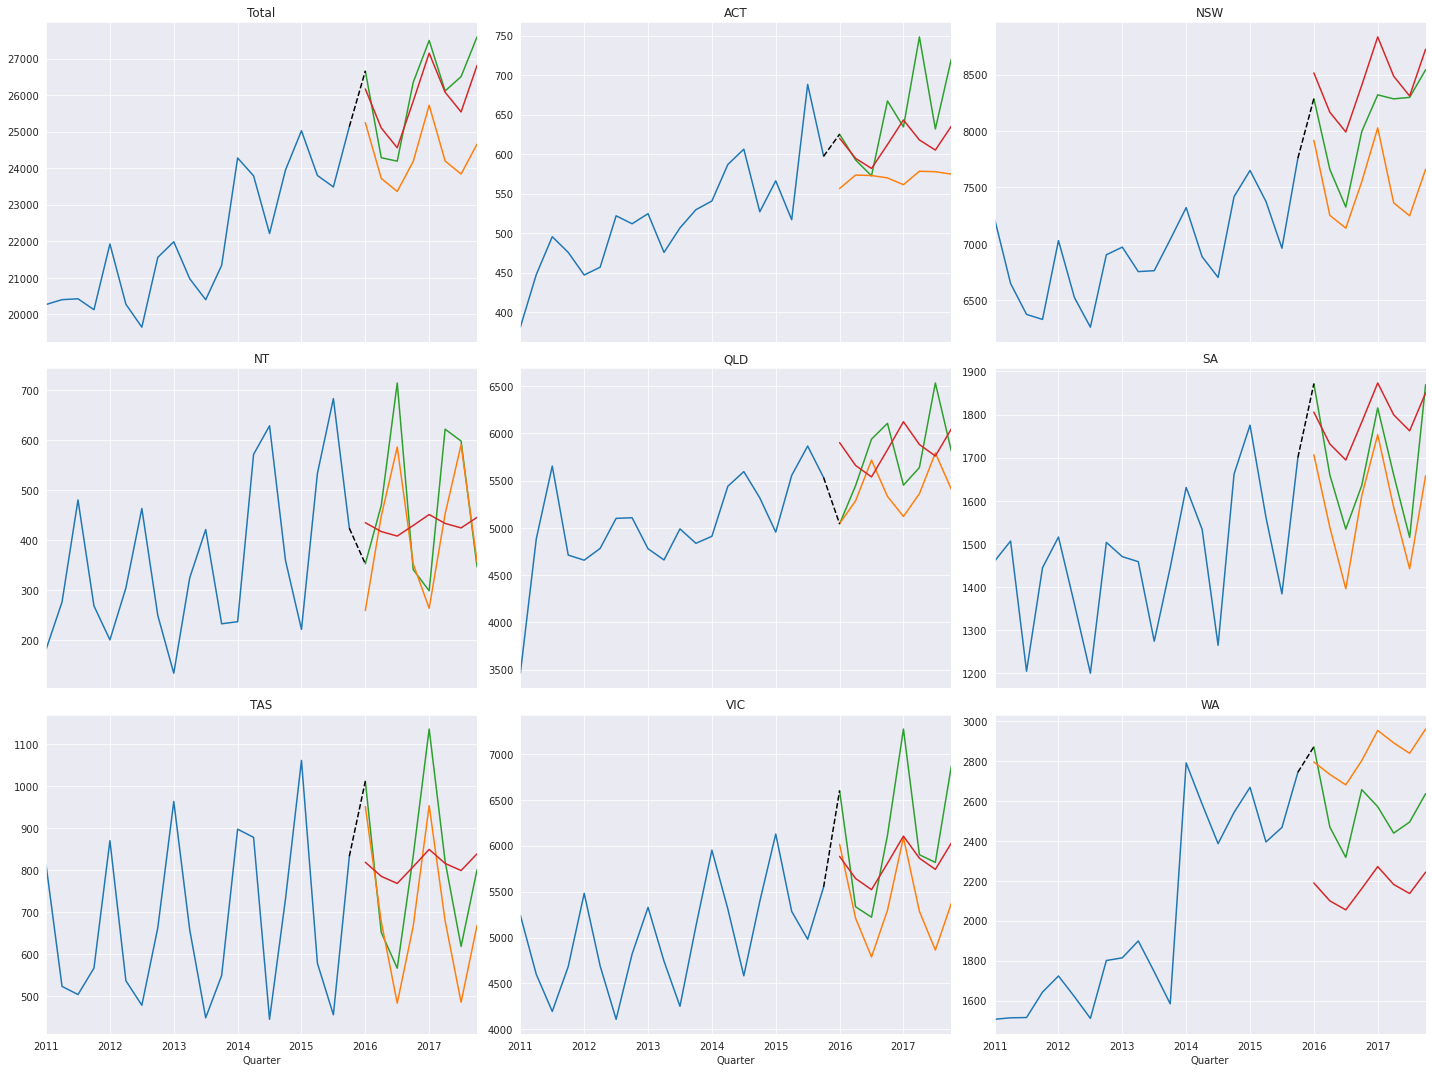

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True)
for ax, col in zip(axes.flat, df_train_states):
    ax.set_title(col)
    df_train_states.loc['2011Q1':, col].plot(ax=ax, c='tab:blue')
    df_test_states.loc['2011Q1':, col].plot(ax=ax, c='tab:green')
    df_forecast_bu_states.loc['2011Q1':, col].plot(ax=ax, c='tab:orange')
    df_forecast_td_states.loc['2011Q1':, col].plot(ax=ax, c='tab:red')
    # Connector
    ax.plot([df_train_states.index[-1], df_test_states.index[0]],
            [df_train_states.iloc[-1][col], df_test_states.iloc[0][col]],
            'k--'
           )
fig.tight_layout()

### Q. Post Mortem

Which strategy is better? BU or TD?

How would you <u>quantitatively</u> evaluate which strategy performed better? (This is NOT a trivial question. I suggest you do research.)

### Answer.

`Visually, I'll give it to BU-forecasts when it comes to focecasting state-level forecasts due to its bottom-up approach. That means that forecasts are more fit to the lower level (in the heirarchy) time series. However, for the total forecast, I'll give it to TF-forecasts. Just look at how close the plot is when it comes to the aggregated total.`

`That said, here is a quantitative comparison of the the two methods:`

In [32]:
(pd.DataFrame(
    pd.concat(methods, axis=1, keys=['BU', 'TD']).mean().rename(level)
    for methods, level
    in zip([[bu_tot, td_tot], [bu_sta, td_sta], [bu_reg, td_reg]],
           ['Total', 'State', 'Region']))
 .swaplevel(axis=1)
 .sort_index(axis=1))

MAE              MASE               RMSE          
               BU        TD      BU      TD         BU        TD
Total   1783.8892  539.6548  1.6056  0.4857  1944.8443  609.3173
State    295.6355  260.8654  1.0825  1.0958   338.7886  305.6689
Region    40.6720   47.3699  0.8533  0.9227    49.2867   57.5254

`Perhaps the only metric worth comparing vertiaclly here is the MASE, which is of the same scale because "scaled". Also, because as the time series values get bigger, such as when dealing with those higher up in the heirarchy, e.g., State vs Region, the higher level gives bigger RMSE & MAE. We now look at the average for all 85 (1 Total + 8 States + 76 Regions) time series forecasts as done in the book.`(https://otexts.com/fpp3/tourism.html)

In [27]:
(pd.concat([
    pd.concat(methods, axis=1, keys=['BU', 'TD']) for methods
    in [[bu_tot, td_tot], [bu_sta, td_sta], [bu_reg, td_reg]]])
 .mean()
 .rename('All Series')
 .unstack()
 .sort_index(axis=1))

,MAE,MASE,RMSE
BU,85.1770,0.8837,98.8346
TD,73.2552,0.9339,87.3717


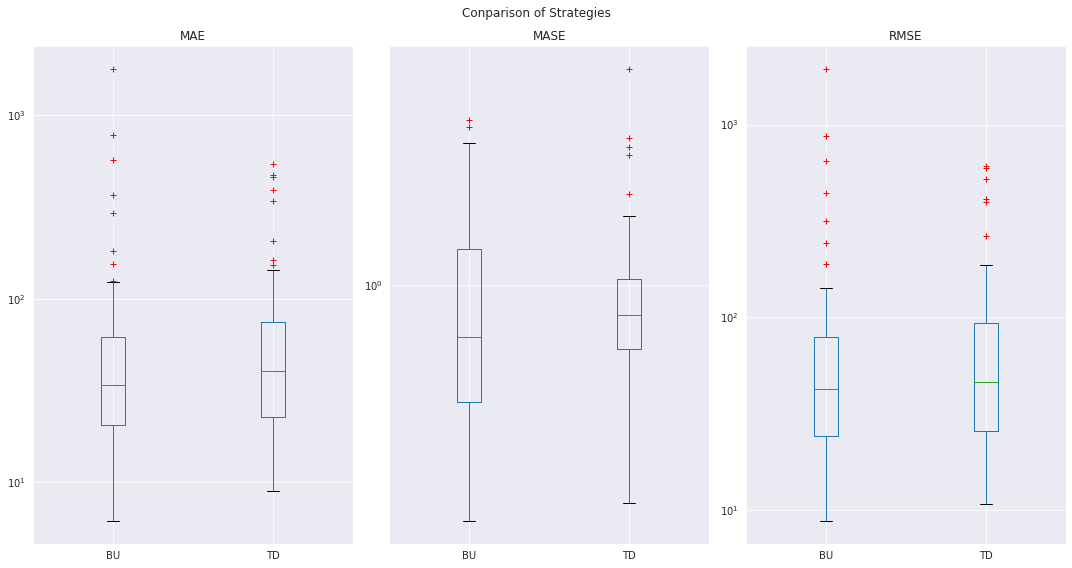

In [148]:
fig, axes = plt.subplots(figsize=(15,8), ncols=3, sharey=False)
(pd.concat([
    pd.concat(methods, axis=1, keys=['BU', 'TD']) for methods
    in [[bu_tot, td_tot], [bu_sta, td_sta], [bu_reg, td_reg]]])
 .stack(level=0)
 .reset_index(level=1)
 .boxplot(by='level_1', sym='r+', figsize=(24,8), layout=(1,3), ax=axes)
)

plt.suptitle('Conparison of Strategies')
[(ax.set_xlabel(''), ax.set_yscale('log')) for ax in axes]
plt.tight_layout()

`TD wins on RMSE and MAE but BU wins on MASE. Truly, the serve different purposes. I'd choose TD for Total and State-level, and BU for Regional-level. But if thou shall insist on only one, I'd take TD; the spread of its metrics seems more consistent.`